In [21]:
##### optuna 7 SVR / NN / RFR  catogorical only ######

import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv(r"C:\\Users\\JellevanAs\\Documents\\Studie\\Thesis\\df-englisch_cat.csv")
df = df.drop(df.columns[0], axis=1)
# Extract 'numerical_price' as target variable
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' and 'numerical_price' columns from df
x = df.drop(["ada_embedding_eng", "numerical_price"], axis=1)

# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]


In [22]:
x.columns.tolist()

['num_bedrooms',
 'num_rooms',
 'building_type_Bestaande bouw',
 'building_type_Nieuwbouw',
 'building_type_na',
 'tag_k.k.',
 'tag_v.o.n.',
 'house_category_Appartement',
 'house_category_Bungalow',
 'house_category_Eengezinswoning',
 'house_category_Grachtenpand',
 'house_category_Herenhuis',
 'house_category_Landhuis',
 'house_category_Other',
 'house_category_Unknown',
 'house_category_Villa',
 'house_category_Woonboerderij',
 'house_category_Woonboot',
 'energy_label_encoded',
 'size_scaled',
 'longitude_scaled',
 'latitude_scaled']

In [23]:
del df

In [24]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_rf_cat(trial):
    # Parameters
    max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt',])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 25, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 25, step=2)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    rf_params = dict(max_depth=max_depth, n_estimators=n_estimators, 
                     max_features=max_features, min_samples_leaf=min_samples_leaf, 
                     min_samples_split=min_samples_split, bootstrap=bootstrap)

    clf_rf_opt = RandomForestRegressor(**rf_params, n_jobs=-1)

    # StandardScaler for y
    scaler = StandardScaler()

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Scaling y_train
        y_train_scaled = scaler.fit_transform(np.array(y_train_fold).reshape(-1, 1)).flatten()


        # Fitting the model
        clf_rf_opt.fit(X_train_fold, y_train_scaled)

        # Predicting and inverse transformation
        y_pred_scaled = clf_rf_opt.predict(X_test_fold)
        y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()


        # R2 Score
        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return float(np.mean(r2_scores))

study_rf = optuna.create_study(directions=['maximize'])
study_rf.optimize(Objective_rf_cat, n_trials=50)

[I 2024-01-06 12:47:46,394] A new study created in memory with name: no-name-7852a9e6-602e-4c3e-8eb6-e0dae80f8b8c


C:\Users\JellevanAs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [2, 25] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 24].
  warnings.warn(
[I 2024-01-06 12:47:49,889] Trial 0 finished with value: 0.39217171362645475 and parameters: {'max_depth': 3, 'n_estimators': 400, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 12, 'bootstrap': False}. Best is trial 0 with value: 0.39217171362645475.
C:\Users\JellevanAs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [2, 25] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 24].
  warnings.warn(
[I 2024-01-06 12:48:00,257] Trial 1 finished with value: 0.552372596358

C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\3654072024.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\3654072024.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\3654072024.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rf)


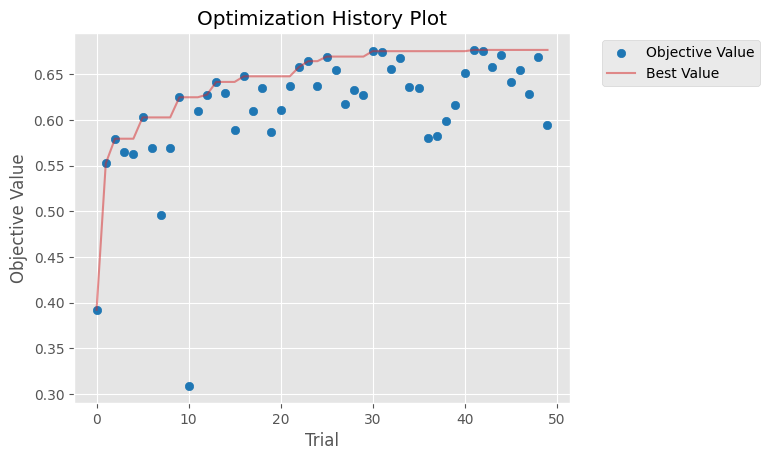

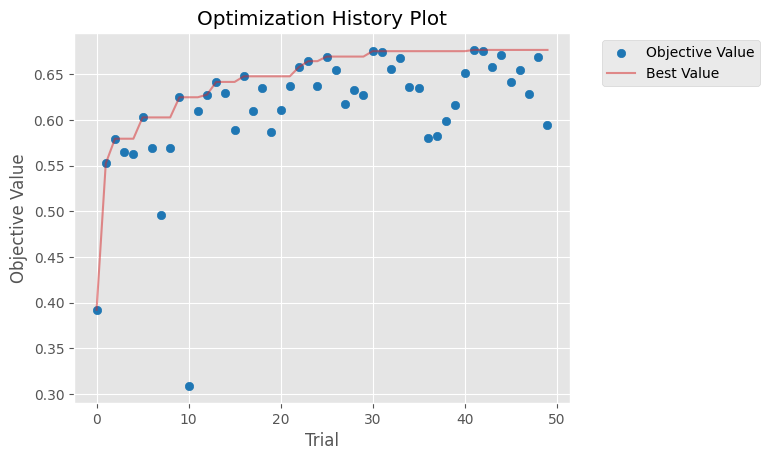

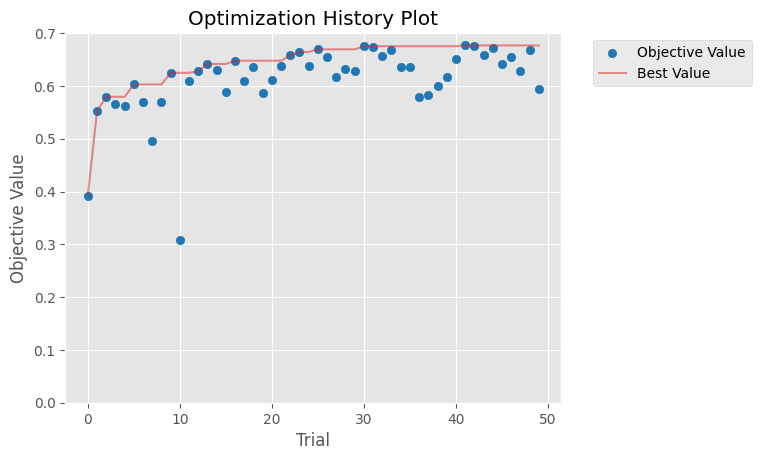

In [25]:

from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

optuna.visualization.matplotlib.plot_optimization_history(study_rf)
optuna_matplotlib.plot_optimization_history(study_rf)

plt.ylim(0, 0.7)

# Show the plot
plt.show()

In [26]:
##### optuna 7 SVR / NN / RFR  catogorical only ######

import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv(r"C:\\Users\\JellevanAs\\Documents\\Studie\\Thesis\\df-englisch_cat.csv")
df = df.drop(df.columns[0], axis=1)
# Extract 'numerical_price' as target variable
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' and 'numerical_price' columns from df
x = df.drop(["ada_embedding_eng", "numerical_price"], axis=1)

# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]


In [27]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


In [28]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_linear_svr(trial):
    # Parameters for LinearSVR
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
    tol = trial.suggest_loguniform("tol", 1e-5, 1e-1)
    loss = trial.suggest_categorical("loss", ['epsilon_insensitive', 'squared_epsilon_insensitive'])

    # Ensure compatible settings for dual and loss
    if loss == 'epsilon_insensitive':
        dual = True  # dual must be True for 'epsilon_insensitive'
    else:
        dual = trial.suggest_categorical("dual", [True, False])

    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    intercept_scaling = trial.suggest_uniform("intercept_scaling", 0.1, 10)
    max_iter = trial.suggest_int("max_iter", 1000, 10000)

    linear_svr_params = dict(C=C, epsilon=epsilon, tol=tol, loss=loss, 
                             fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, 
                             dual=dual, max_iter=max_iter)

    clf_linear_svr = LinearSVR(**linear_svr_params, random_state=0)

    # StandardScaler for y
    scaler = StandardScaler()

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        # Scaling y_train
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()
        y_train_scaled = y_train_scaled.ravel()

        # Fitting the model
        clf_linear_svr.fit(x_train_fold, y_train_scaled)

        # Predicting and inverse transformation
        y_pred_scaled = clf_linear_svr.predict(x_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # R2 Score
        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)


    return float(np.mean(r2_scores))


In [29]:
study_svr = optuna.create_study(directions=['maximize'])
study_svr.optimize(Objective_linear_svr, n_trials=50)

[I 2024-01-06 12:56:27,676] A new study created in memory with name: no-name-ab13bcf3-3837-434c-b765-947171c0a806
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\750791288.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\750791288.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\750791288.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\1863870014.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\1863870014.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_7524\1863870014.py:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_svr)


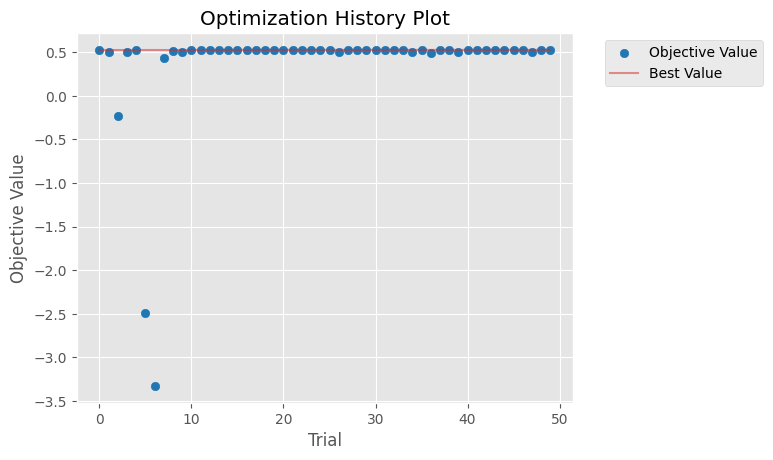

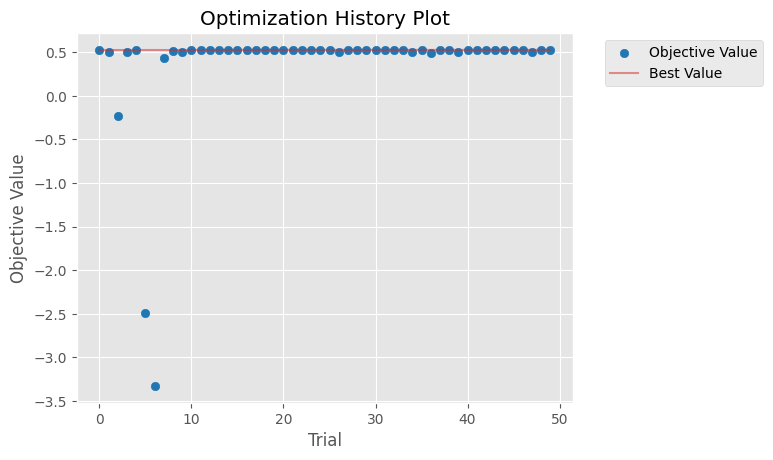

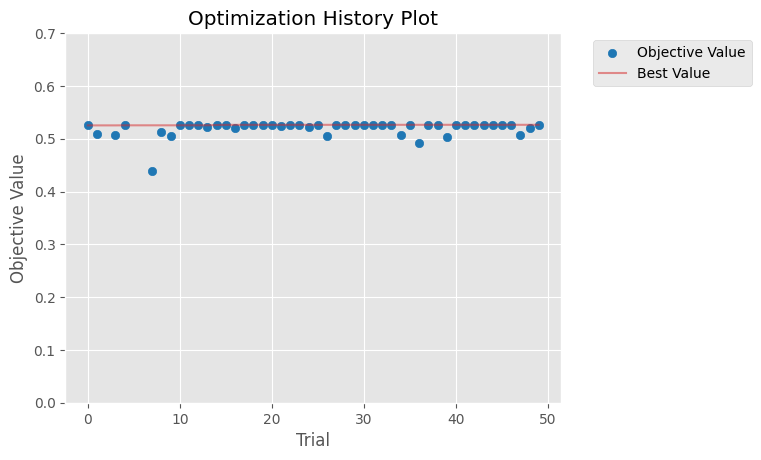

In [30]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna_matplotlib.plot_optimization_history(study_svr)

plt.ylim(0, 0.7)

plt.show()